In [34]:
%%HTML
<style> code {background-color : pink !important;} </style>

# Advanced Lane Finding Project

## Camera Calibration with OpenCV
===

The code for this step is contained in the first code cell of the IPython notebook located in "./examples/example.ipynb" (or in lines # through # of the file called `some_file.py`).  

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  
 

In [49]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'corners_found/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()
print("objpoints and imgpoints are ready!")

objpoints and imgpoints are ready!


Now I have `objpoints` and `imgpoints` needed for camera calibration.  Now I calculate distortion coefficients, and test undistortion on an image.

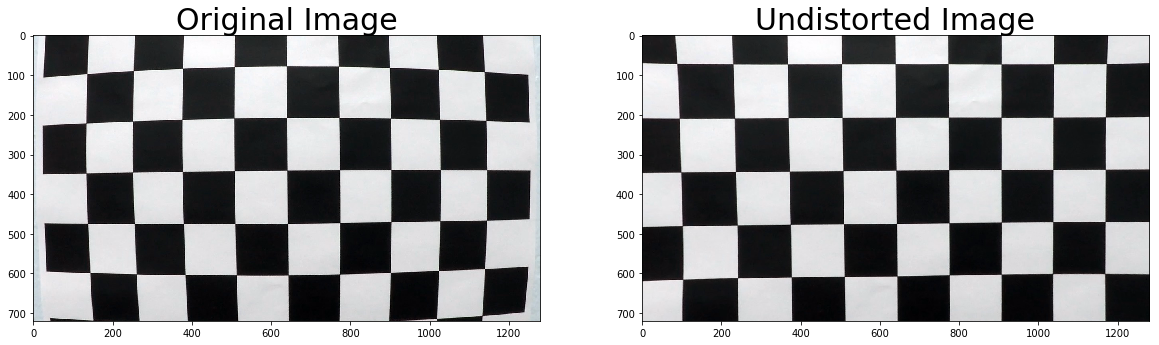

In [50]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/calibration1_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Distortion Correction
Now to undistort the image I need to load the calibration results and use them to undistort my images. 

In [51]:
# Load Calibration results
dist_pickle = pickle.load( open ("camera_cal/wide_dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

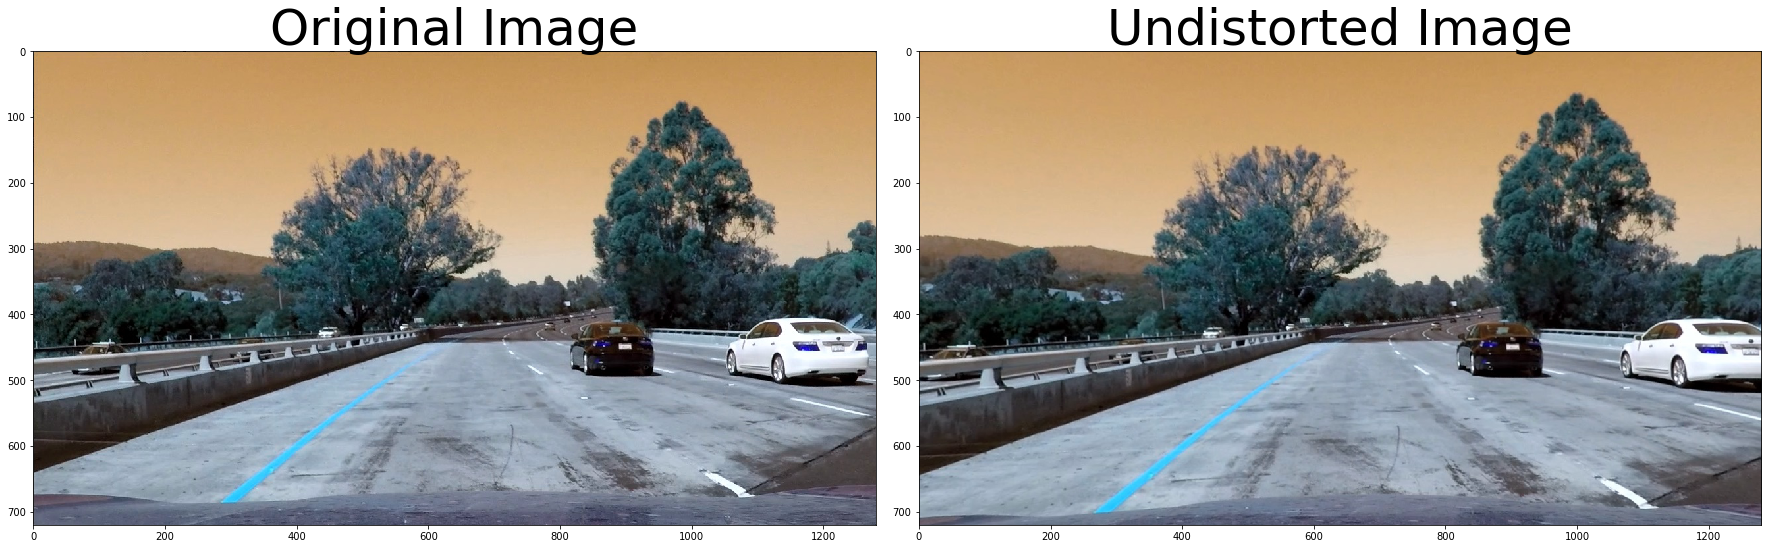

In [52]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in an image
img = cv2.imread('./test_images/test1.jpg')

# This is a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    img_size = img.shape[0:2]
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Combining Thresholds
Followings are the functions defined to do different tasks in color and gradient thresholding. I tested all of these methods indivually on one the test images which seems to have the most complex conditions of shaddows and road colors, and figured out which one gives the best result. Then I tried different combination of them. 

You can find method Combined_Thresholding(img) in Template.py defiend at line 92.

In [53]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    #    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img[:,:,0]
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient =='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    #    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = image[:,:,0]
    xSobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    ySobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobel = np.sqrt(xSobel**2 + ySobel**2)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    #    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = image[:,:,0]
    xSobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0 , ksize=sobel_kernel)
    ySobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1 , ksize=sobel_kernel)
    abs_xSobel = np.absolute(xSobel)
    abs_ySobel = np.absolute(ySobel)
    direction = np.arctan2(abs_ySobel, abs_xSobel)
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return dir_binary

def color_threshold(image, sobel_kernel=3, sthresh=(0,255), vthresh=(0,255)):
    
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    s_binary = np.zeros_like(s)
    s_binary[(s >= sthresh[0]) & (s <= sthresh[1])] = 1
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v = hsv[:,:,2]
    v_binary = np.zeros_like(v)
    v_binary[(v >= vthresh[0]) & (v <= vthresh[1])] = 1
    
    output = np.zeros_like(s)
    output[(s_binary == 1) & (v_binary == 1)] = 1
    return output


### Visualizaiton of Combined Thresholding
Later in the code, in my pipeline Process_frames method, I use the combination of gradx, grady and color_threshodling on V and S channels as the best results I could get so far. However I am using the same combination here to visualize the result of my Combined thresholding on one of the test images. I used the same block of codes to test each and combination of them on test images. The result is a binary image which the lane lines are clearly recognizable.

image shape [47 53 75]


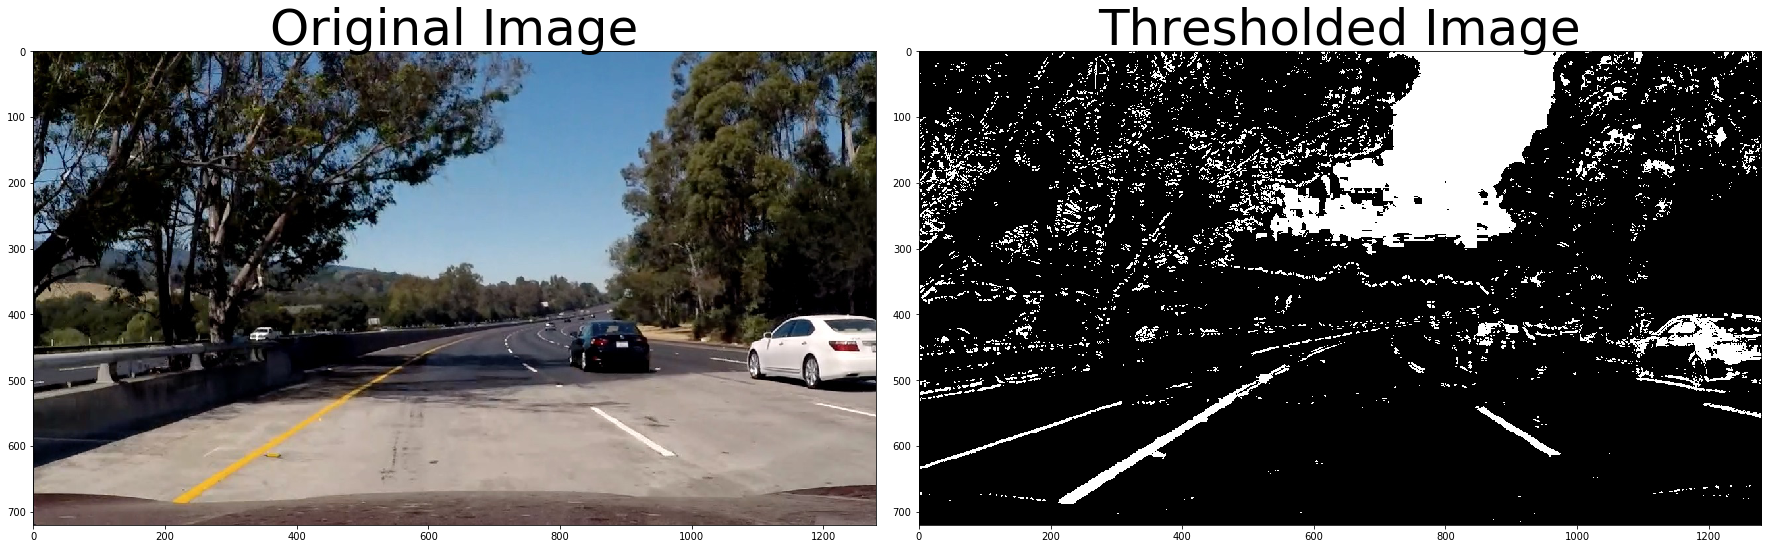

In [67]:
import pickle
import numpy as np
import cv2
import glob
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

ksize = 9 # Choose a larger odd number to smooth gradient measurements
image = mpimg.imread('test_images/test5.jpg')

# Apply each of the thresholding functions
ColorCombined = np.zeros_like(image[:,:,0])
print("image shape",image[0][0])
copy_combined = combined

# gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(12,255))

grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(40, 255))

col_binary = color_threshold(image, sobel_kernel=ksize, sthresh= (100,255) , vthresh=(50, 255))


ColorCombined[((gradx == 1) & (grady == 1)) | ( col_binary == 1)] = 255 # & (dir_binary == 1) & (mag_binary == 1) ] = 255
   
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(ColorCombined, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()



## Perspective Transform
After Calibrating the Camera and undistorting images, we should apply a perspective transform. This will help us to eventually calculate the lane curviture. 
To do a perspective transform, we need to do the following steps:
    * Undistort the image using cv2.undistort() with mtx and dist
    * Convert to grayscale
    * Find the chessboard corners
    * Draw corners
    * Define 4 source points (the outer 4 corners detected in the chessboard pattern)
    * Define 4 destination points (I decided to hardcode these)
    * Use cv2.getPerspectiveTransform() to get M, the transform matrix
    * use cv2.warpPerspective() to apply M and warp your image to a top-down view
In the code "Template.py" you can find method Warped() that does the transformation defined at line 78.

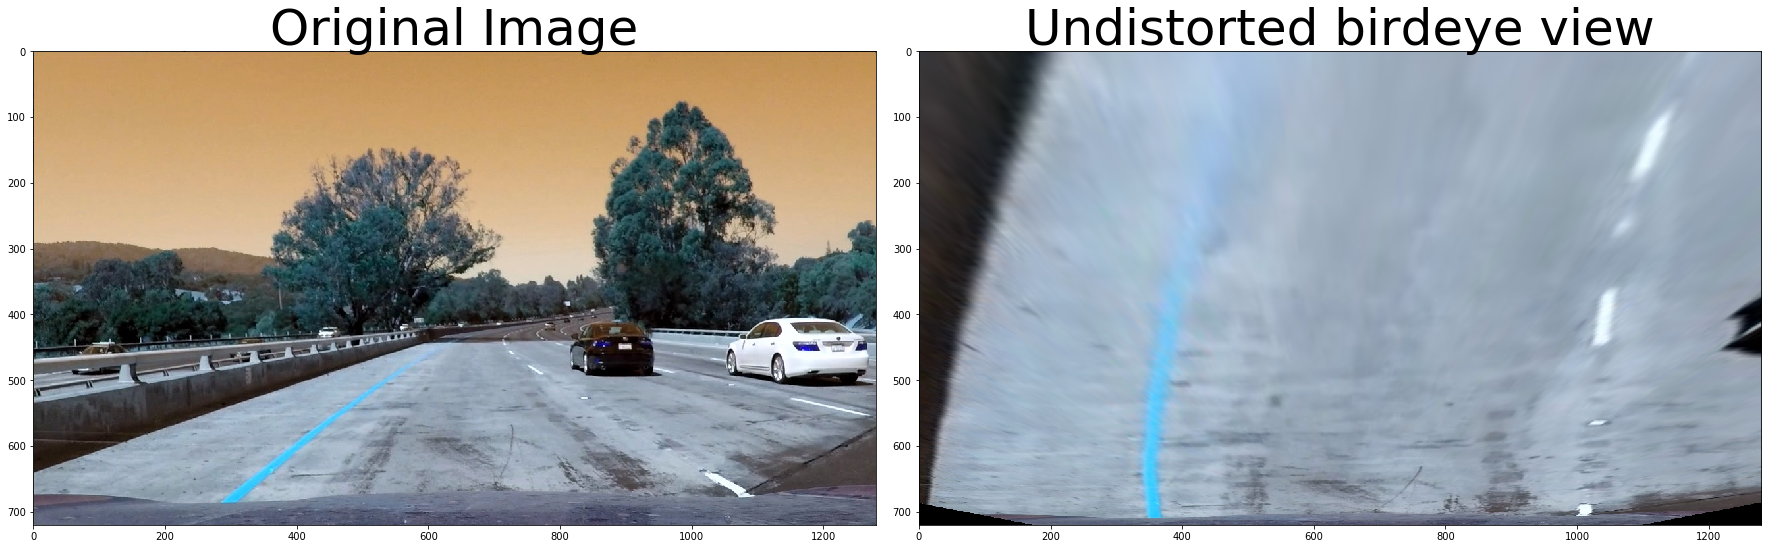

In [72]:
# Transform Prespective
img_size = (img.shape[1], img.shape[0]) # shape = [720, 1280]

src = np.float32([[590,450], [690,450], [1120,img_size[1]], [ 200,img_size[1]]])
dst = np.float32([[320 ,0], [980,0], [980,img_size[1]], [320,img_size[1]]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(img, M, img_size)

top_down, perspective_M = warped, M
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted birdeye view', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


The result is a warped image which the lines are parallel enough to work with. However in the code I applied the transform on the combined thresholding result image which is easier to work with. 

## Locate the Lane Lines
To locat the lane line pixels first we can identify the starting point of both lane lines at the bottom of image, by taking a histogram on the pixel values of image over the bottom half of image pixeels. After defining our search window charactristics, we can slide out searching window along the image and identify the none zero pixels of the lane lines within a margin and stroe the indices.
After finding the lane line pixels it's time to fit a polynomial to the pixels found. Now that we have the polynomial information of the lane line pixels, in next frame finding the lane lines pixels would be much easier. 

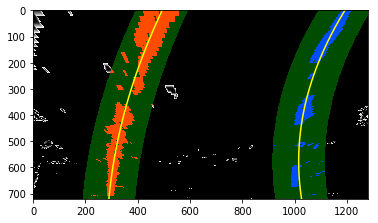

In [77]:
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
        
    # Generate x and y values for plotting
#    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
#    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
#
#    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#    plt.imshow(out_img)
#    plt.plot(left_fitx, ploty, color='yellow')
#    plt.plot(right_fitx, ploty, color='yellow')
#    plt.xlim(0, 1280)
#    plt.ylim(720, 0)
#    plt.show()

############################################################################
    # Assume you now have a new warped binary image
    # from the next frame of video (also called "warped")
    # It's now much easier to find line pixels!
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()


## Measuring the Curvature
To Measure the curvature I picked the bottom of image, as the center of the curve. At the end I took average of left and right lane curvature as the resulting redius.


1926.95809872 973.804531826
467.975878411 m


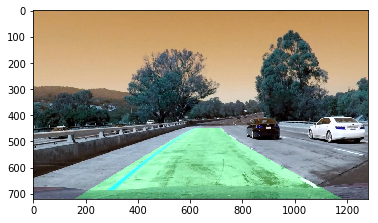

In [78]:
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image

    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    y_eval = np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)
        # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(np.array(lefty, np.float32) * ym_per_pix, np.array(leftx, np.float32) * xm_per_pix, 2)
    right_fit_cr = np.polyfit(np.array(righty, np.float32) * ym_per_pix, np.array(rightx, np.float32) * xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]* ploty *ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]* ploty *ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    left_curv_mean = np.mean(left_curverad)
    right_curv_mean = np.mean(right_curverad)
    radius_curv = (left_curv_mean + right_curv_mean)/2

    #print(left_curv_mean, 'm', right_curv_mean, 'm')
    print(radius_curv, 'm')
        # Example values: 632.1 m    626.2 m


    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    plt.imshow(result)


## Video PipeLine 
I have tried both approches of sliding windows to locate the lane lines. The first link is the output result without convolution approach:

https://youtu.be/y0DiigwMyp4

and the second one is with convolution approach:

https://youtu.be/HeoLdBYa3yM

In the submitted zipped file, you can find two files including the video pipeline. Template.py imports class Line() and uses Convolution approach to locate the lane lines. The result of this pipeline is output_video1.mp4. Template2.py however, does not uses this approach and you can see the result saved as output_video.py.
Video pipeline is defined at 109 in Template.py as Process_frames(image) and in Template2.py at line 86.

## Discussion

Using the convolution approach, I found some jittering on detected lane lines, starting from the moment that a car enters the frames and passes by the car. It seems that the white pixels of the wheals of the car, could get mixed with the lane line white pixels. However when I tried the regular approach of sliding windows, I found it more robust. 
using 9 as kenral size while doing combined thresholding gave me the best result, as well as the combination thresholding on SV channels and gradx and gray. Surprisingly other thresholdings didnot give me the best results so I left them out.